In [2]:
import sys
import os
from pathlib import Path

REPO_PATH = r"C:\Users\tskor\Documents\GitHub\inovation_project\1_Code_Base" # Specify a local path to the repository (or use installed package instead)
os.environ["WANDB_DIR"] = r"C:\Users\tskor\Documents\GitHub\inovation_project\1_Code_Base"
sys.path.append(REPO_PATH)

PROJECT_ROOT = Path.cwd().parent.parent

from models.mlp import Mlp, mlp_data_preparation
from models.lstm import LstmWithAttention, lstm_data_preparation
from models.cnn import Cnn2D, cnn_data_preparation

import numpy as np
from data.test_train_split import test_train_split
import matplotlib.pyplot as plt
import tensorflow as tf
from models.utils import pen_low_loss
import wandb
from scipy import stats
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split


#### Data preparation

In [3]:
config_data = {
    "months": 3,
    "num_bands": 9,
    "num_buckets": 60,
    "batch_size": 32,
}

dataset_path = rf"{PROJECT_ROOT}\2_Data\dataset_nan_map_True_norm_True_{config_data['num_buckets']}_buckets_{config_data['num_bands']}_bands_60_dataset_fips.npy"   
labels_path = rf"{PROJECT_ROOT}\2_Data\dataset_nan_map_True_norm_True_{config_data['num_buckets']}_buckets_{config_data['num_bands']}_bands_60_labels.npy"



#### Linear regression

In [10]:
# Same dataset preparation as for MLP
mlp_dataset, labels = mlp_data_preparation(dataset_path, labels_path)
x_train, x_test, y_train, y_test = train_test_split(mlp_dataset, labels, test_size=0.2, random_state=42)

lr = Ridge(alpha=1.0)
lr.fit(x_train, y_train)

#Evaluaation
lr_predictions = lr.predict(x_test)
lr_mse = sum((lr_predictions - y_test)**2) / len(y_test)
lr_mae = sum(abs(lr_predictions - y_test)) / len(y_test)

print(f"Linear regression RMSE: {np.sqrt(lr_mse)}")
print(f"Linear regression MAE: {lr_mae}")



Linear regression RMSE: [39.477818]
Linear regression MAE: [26.888323]


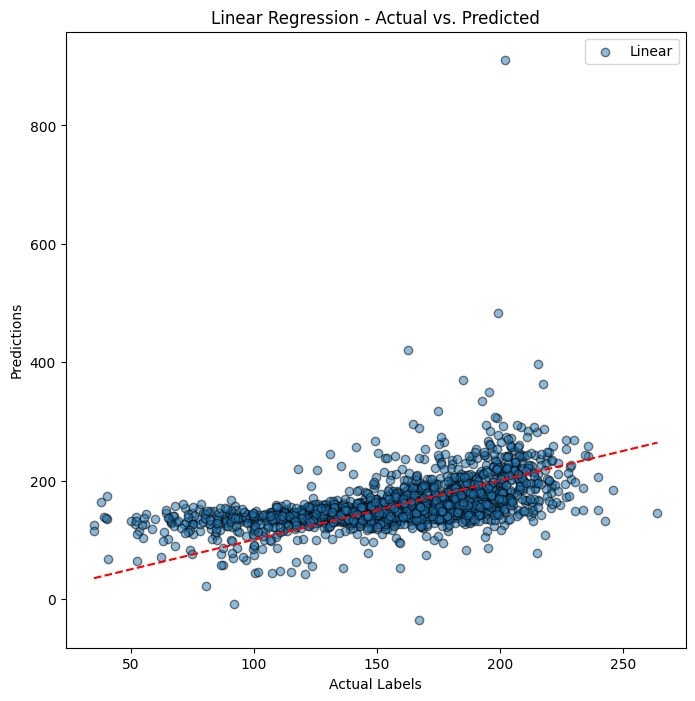


Correlations using scipy.stats.pearsonr:
Linear regression correlation: 0.513 (p-value: 0.000e+00)
Mean of actual labels: 157.30


In [11]:
actual_labels = y_test

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, lr_predictions, alpha=0.5, edgecolors='k', label="Linear")
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('Linear Regression - Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.legend()
plt.show()

lr_corr, lr_p = stats.pearsonr(actual_labels.flatten(), lr_predictions.flatten())
print("\nCorrelations using scipy.stats.pearsonr:")

print(f"Ridge regression correlation: {lr_corr:.3f} (p-value: {lr_p:.3e})")

print(f"Mean of actual labels: {np.mean(actual_labels):.2f}")


#### MLP

In [21]:
mlp_dataset, labels = mlp_data_preparation(dataset_path, labels_path)
mlp_train_dataset, mlp_val_dataset, mlp_test_dataset = test_train_split(mlp_dataset,
                                                            labels,
                                                            **config_data)

In [22]:
mlp_dataset.shape


(9578, 1623)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: t-skorkowski. Use `wandb login --relogin` to force relogin


Epoch 1/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 11196.5225 - mae: 83.5997 - mse: 10542.3877 - val_loss: 17522141184.0000 - val_mae: 3623.9253 - val_mse: 19469045760.0000
Epoch 2/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1492.2245 - mae: 26.0159 - mse: 1095.9576 - val_loss: 6203363840.0000 - val_mae: 2161.7646 - val_mse: 6892626944.0000
Epoch 3/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1074.1918 - mae: 21.4148 - mse: 767.6807 - val_loss: 3995170048.0000 - val_mae: 1738.8037 - val_mse: 4439077376.0000
Epoch 4/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 966.6809 - mae: 20.0136 - mse: 702.3347 - val_loss: 3042957056.0000 - val_mae: 1519.8662 - val_mse: 3381063680.0000
Epoch 5/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 895.3566 - mae: 18.9277 - mse: 649.4860 - val_loss: 2775066368.0000 - val_mae: 1452.3457 - val_mse: 3083406848.0000
Epoch 6/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 849.6985 - mae: 18.1334 - mse: 610.1669 - val

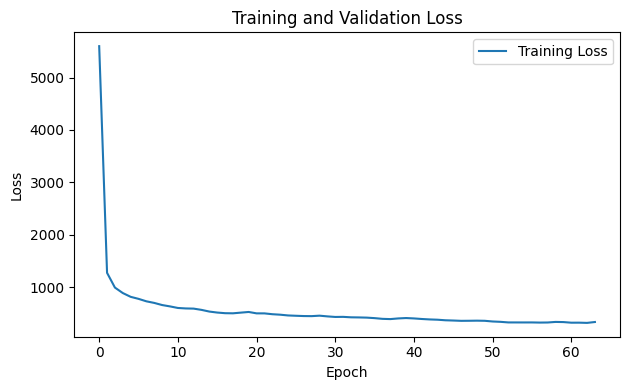

epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▇▆▆▆▅▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/mse,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▆▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mae,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mse,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,63
epoch/learning_rate,0.001
epoch/loss,334.8392


In [11]:

mlp_config = {
    "input_shape": (config_data["months"]
                  * config_data["num_buckets"]
                  * config_data["num_bands"],),
    "no_units": [100,] * 5,
}
mlp_model = Mlp(**mlp_config)
mlp_model.compile(learning_rate=0.00001, loss=pen_low_loss, metrics=["mae", "mse"])
mlp_model.fit(mlp_train_dataset,
         mlp_val_dataset,
         epochs=300)

# After training
original_weights = [w.numpy() for w in mlp_model.weights]

mlp_model.trainable = False
wandb.finish()  

In [12]:
mlp_eval = mlp_model.evaluate(mlp_test_dataset)
print(mlp_eval)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 994.1878 - mae: 21.1930 - mse: 750.1146
[1065.5382080078125, 21.19029426574707, 744.75537109375]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


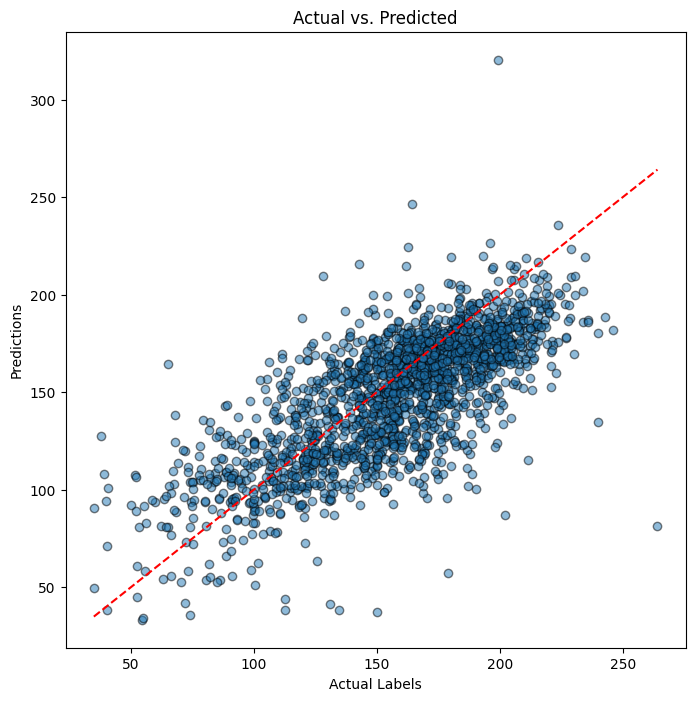

In [13]:
mlp_predictions = mlp_model.predict(mlp_test_dataset)
actual_labels = np.concatenate([response.numpy() for _, response in mlp_test_dataset], axis=0)

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, mlp_predictions, alpha=0.5, edgecolors='k')
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.show()

In [14]:
test_responses = []
for _, response in mlp_test_dataset:
    test_responses.append(response.numpy())

test_responses = np.concatenate(test_responses, axis=0)

mean_train_response = tf.reduce_mean([y for _, y in mlp_train_dataset]).numpy()

baseline_loss = sum(((mean_train_response - test_responses) ** 2)/len(test_responses))
print(sum(baseline_loss))


1402.0701904296875


#### LSTM

In [15]:
lstm_dataset, labels = lstm_data_preparation(dataset_path, labels_path)
lstm_train_dataset, lstm_val_dataset, lstm_test_dataset = test_train_split(lstm_dataset,
                                                                            labels,
                                                                            **config_data)

Epoch 1/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 17943.8945 - mae: 126.5020 - val_loss: 6049.8516 - val_mae: 69.8472
Epoch 2/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 4653.0234 - mae: 60.2028 - val_loss: 2135.9653 - val_mae: 39.1364
Epoch 3/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 1843.6498 - mae: 36.3464 - val_loss: 1529.4260 - val_mae: 31.7856
Epoch 4/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 1433.7640 - mae: 30.8951 - val_loss: 1482.9723 - val_mae: 30.7953
Epoch 5/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 1399.4784 - mae: 30.0028 - val_loss: 1482.0162 - val_mae: 30.6760
Epoch 6/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 1397.3912 - mae: 29.8754 - val_loss: 1482.1539 - val_mae: 30.6607
Epoch 7/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 1397.2385 - mae: 29.8574 - val_loss: 1482.1069 - val_mae: 30.6587
Epoch 8/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 1403.8757 - mae: 29.8948 - val_loss: 14

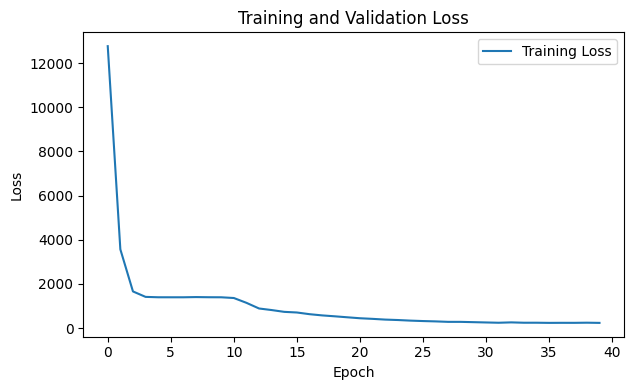

epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mae,█▄▃▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,39
epoch/learning_rate,0.001
epoch/loss,236.91646
epoch/mae,10.08964
epoch/val_loss,583.49146


In [16]:
train_lstm = True

if train_lstm:
    wandb.init(project="blue-marble")
    config_lstm = {
        "input_shape": (config_data["months"], config_data["num_buckets"] * config_data["num_bands"]),
        "no_lstm_units": [200,] * 7,
        "attention_units": 200,
    }
    lstm_model = LstmWithAttention(**config_lstm)
    lstm_model.compile(learning_rate=0.00013)
    lstm_model.fit(lstm_train_dataset,
            lstm_val_dataset,
            epochs=300)

    lstm_model.trainable = False
    wandb.finish()
else:
    model_path = r"{PROJECT_ROOT}\1_Code_Base\models\saved\\"
    model_name = "LSTM-angry-mayo-20241101-102955.keras"
    lstm_model = tf.keras.models.load_model(model_path + model_name)
    lstm_model.compile()

In [17]:
lstm_eval = lstm_model.evaluate(lstm_test_dataset)
print(lstm_eval)

print(f"LSTM detalis: {lstm_model.summary()}")


 7/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 409.1908 - mae: 16.1231 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 541.7834 - mae: 17.9431
[581.9029541015625, 18.437572479248047]


Model: "lstm_with_attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (32, 3, 200)           │       593,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ ?                      │        80,601 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (32, 1)                │           401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,798,208 (29.75 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,599,402 (9.92 MB)

 Optimizer params: 5,198,806 (19.83 MB)

LSTM detalis: None


#### CNN

In [18]:
config_data = {
    "months": 3,
    "num_bands": 9,
    "num_buckets": 60,
    "batch_size": 32,
}

dataset_path = rf"{PROJECT_ROOT}\2_Data\test_data\dataset_nan_map_True_norm_True_{config_data['num_buckets']}_buckets_{config_data['num_bands']}_bands_60_dataset.npy"   
labels_path = rf"{PROJECT_ROOT}\2_Data\test_data\dataset_nan_map_True_norm_True_{config_data['num_buckets']}_buckets_{config_data['num_bands']}_bands_60_labels.npy"

In [19]:

cnn_dataset, labels = cnn_data_preparation(dataset_path, labels_path, **config_data)
cnn_train_dataset, cnn_val_dataset, cnn_test_dataset = test_train_split(cnn_dataset,
                                                                            labels,
                                                                            **config_data)

In [20]:
print(config_data["months"], config_data["num_buckets"], config_data["num_bands"], sep=", ")


3, 60, 9


Epoch 1/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - loss: 6732.4922 - mae: 59.4393 - val_loss: 1965.5952 - val_mae: 35.5251
Epoch 2/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 1522.6731 - mae: 28.7324 - val_loss: 1609.3943 - val_mae: 31.4347
Epoch 3/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 1308.8420 - mae: 26.3644 - val_loss: 1373.3932 - val_mae: 28.3553
Epoch 4/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 1200.2672 - mae: 25.1354 - val_loss: 1152.4722 - val_mae: 24.9240
Epoch 5/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - loss: 1100.4858 - mae: 23.9477 - val_loss: 1049.1719 - val_mae: 23.2107
Epoch 6/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - loss: 1032.2775 - mae: 23.1126 - val_loss: 1010.8702 - val_mae: 22.8165
Epoch 7/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 990.4517 - mae: 22.6114 - val_loss: 995.0599 - val_mae: 22.8355
Epoch 8/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 958.3024 - mae: 22.2483 - val_loss: 

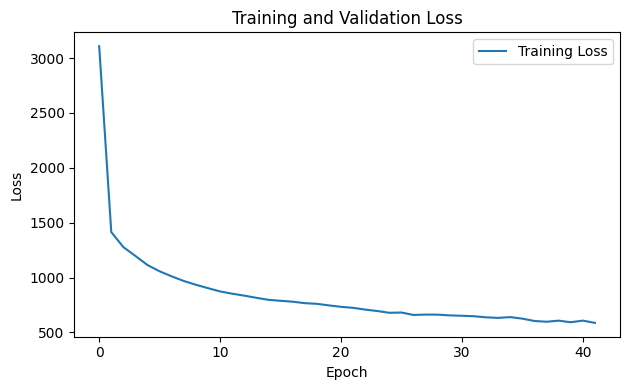

epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▆▅▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▁▁▁▂▂
epoch/val_mae,█▆▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▂▁▂▁▂▂
epoch/epoch,41
epoch/learning_rate,0.001
epoch/loss,586.4837
epoch/mae,16.6468
epoch/val_loss,866.15393


In [21]:
wandb.init(project="blue-marble")
config_cnn = {
    "input_shape": (config_data["months"], config_data["num_buckets"], config_data["num_bands"]),
    "conv_filters": [348, 128],
    "dense_units": [100] * 3,
    "conv_kernel_size": (3, 3),
    "pool_size": (2, 2),
    "dropout_rate": 0.35,
    "l1_reg": 0.03,
    "l2_reg": 0.03,

}
cnn_model = Cnn2D(**config_cnn)
cnn_model.compile(learning_rate=0.0005)
cnn_model.fit(cnn_train_dataset,
        cnn_val_dataset,
        epochs=300)

cnn_model.trainable = False
wandb.finish()

In [22]:
cnn_eval = cnn_model.evaluate(cnn_test_dataset)
print(cnn_eval)


 4/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 718.0310 - mae: 19.5501

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 737.8306 - mae: 19.2918
[738.7406616210938, 19.234966278076172]


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


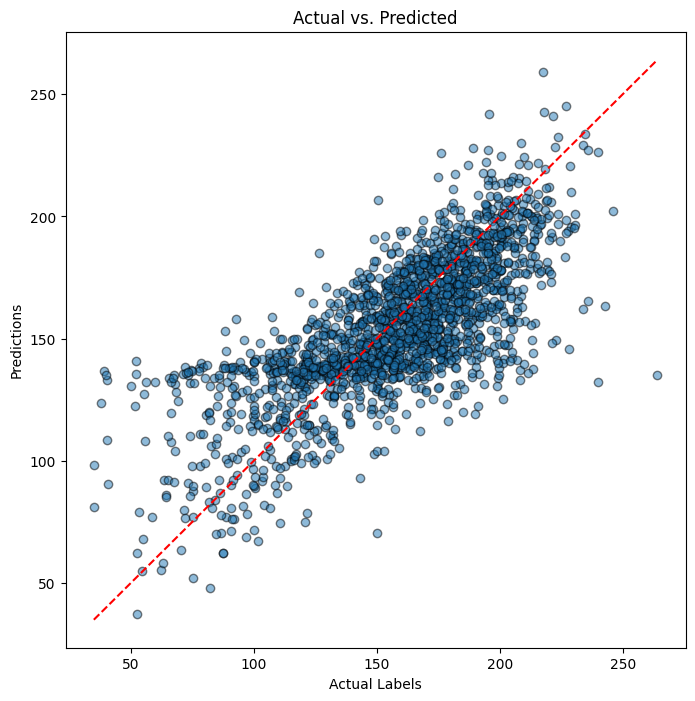


Correlations using scipy.stats.pearsonr:
CNN correlation: 0.746 (p-value: 0.000e+00)


Model: "Cnn2D-worried-stew-20241104-143036"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (32, 348, 58, 7)       │         9,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 128, 27, 5)       │       200,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 174, 29, 7)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 64, 13, 5)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 4160)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (32, 100)              │       416,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (32, 100)              │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (32, 100)              │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 100)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (32, 1)                │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,940,165 (7.40 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 646,721 (2.47 MB)

 Optimizer params: 1,293,444 (4.93 MB)

CNN detalis: None


In [23]:
cnn_predictions = cnn_model.predict(cnn_test_dataset)
actual_labels = np.concatenate([response.numpy() for _, response in cnn_test_dataset], axis=0)

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, cnn_predictions, alpha=0.5, edgecolors='k')
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.show()

cnn_corr, cnn_p = stats.pearsonr(actual_labels.flatten(), cnn_predictions.flatten())
print("\nCorrelations using scipy.stats.pearsonr:")
print(f"CNN correlation: {cnn_corr:.3f} (p-value: {cnn_p:.3e})")

print(f"CNN detalis: {cnn_model.summary()}")


#### Comparison

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


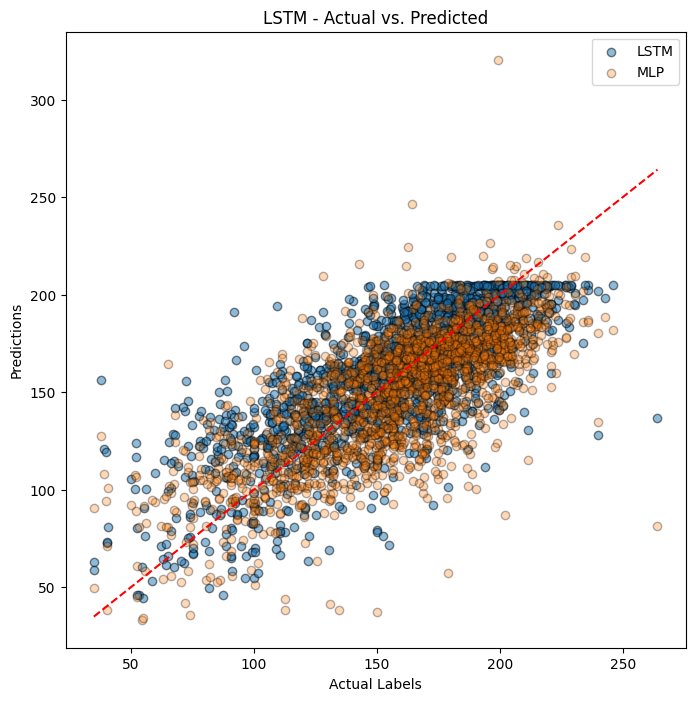


Correlations using scipy.stats.pearsonr:
MLP correlation: 0.736 (p-value: 0.000e+00)
LSTM correlation: 0.775 (p-value: 0.000e+00)
CNN correlation: 0.746 (p-value: 0.000e+00)
Mean of actual labels: 157.40


In [24]:
lstm_predictions = lstm_model.predict(lstm_test_dataset)
actual_labels = np.concatenate([response.numpy() for _, response in lstm_test_dataset], axis=0)

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, lstm_predictions, alpha=0.5, edgecolors='k', label="LSTM")
plt.scatter(actual_labels, mlp_predictions, alpha=0.3, edgecolors='k', label="MLP")
plt.scatter(actual_labels, lr_predictions, alpha=0.5, edgecolors='k', label="Linear")
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('LSTM - Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.legend()
plt.show()

mlp_corr, mlp_p = stats.pearsonr(actual_labels.flatten(), mlp_predictions.flatten())
lstm_corr, lstm_p = stats.pearsonr(actual_labels.flatten(), lstm_predictions.flatten())
cnn_corr, cnn_p = stats.pearsonr(actual_labels.flatten(), cnn_predictions.flatten())
print("\nCorrelations using scipy.stats.pearsonr:")
print(f"MLP correlation: {mlp_corr:.3f} (p-value: {mlp_p:.3e})")
print(f"LSTM correlation: {lstm_corr:.3f} (p-value: {lstm_p:.3e})")
print(f"CNN correlation: {cnn_corr:.3f} (p-value: {cnn_p:.3e})")

print(f"Mean of actual labels: {np.mean(actual_labels):.2f}")



In [25]:
# loss below treshold
low_yield_treshold = 100
low_yeild_mask = actual_labels < low_yield_treshold

low_yield_labels = actual_labels[low_yeild_mask]
mlp_low_predictions = mlp_predictions[low_yeild_mask]
lstm_low_predictions = lstm_predictions[low_yeild_mask]
cnn_low_predictions = cnn_predictions[low_yeild_mask]

mlp_mse_low = sum((mlp_predictions[low_yeild_mask] - actual_labels[low_yeild_mask])**2) / len(low_yeild_mask)
lstm_mse_low = sum((lstm_predictions[low_yeild_mask] - actual_labels[low_yeild_mask])**2) / len(low_yeild_mask)
cnn_mse_low = sum((cnn_predictions[low_yeild_mask] - actual_labels[low_yeild_mask])**2) / len(low_yeild_mask)

print(f"MLP RMSE low yield: {np.sqrt(mlp_mse_low):.2f}")
print(f"LSTM RMSE low yield: {np.sqrt(lstm_mse_low):.2f}")
print(f"CNN RMSE low yield: {np.sqrt(cnn_mse_low):.2f}")
print(f"Low yield %: {float(np.sum(low_yeild_mask)/len(low_yeild_mask)):.2%}")


MLP RMSE low yield: 8.84
LSTM RMSE low yield: 11.43
CNN RMSE low yield: 12.40
Low yield %: 8.37%


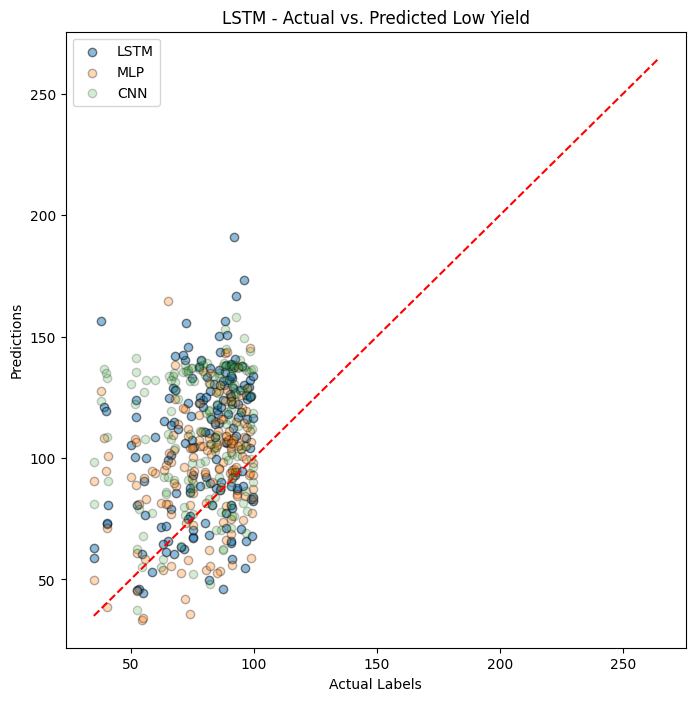

LSTM low yield crop, proportion of correctly predicted yields below the treshold: 40.51%
MLP low yield crop, proportion of correctly predicted yields below the treshold: 50.00%
CNN low yield crop, proportion of correctly predicted yields below the treshold: 35.44%


In [30]:
# Plot low yield actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(low_yield_labels, lstm_low_predictions, alpha=0.5, edgecolors='k', label="LSTM")
plt.scatter(low_yield_labels, mlp_low_predictions, alpha=0.3, edgecolors='k', label="MLP")
plt.scatter(low_yield_labels, cnn_low_predictions, alpha=0.2, edgecolors='k', label="CNN")
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('LSTM - Actual vs. Predicted Low Yield')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.legend()
plt.show()

low_yield_lstm_low_crop = sum(lstm_low_predictions < low_yield_treshold) / len(lstm_low_predictions)
low_yield_mlp_low_crop = sum(mlp_low_predictions < low_yield_treshold) / len(mlp_low_predictions)
low_yield_cnn_low_crop = sum(cnn_low_predictions < low_yield_treshold) / len(cnn_low_predictions)

print(f"LSTM low yield crop, proportion of correctly predicted yields below the treshold: {low_yield_lstm_low_crop:.2%}")
print(f"MLP low yield crop, proportion of correctly predicted yields below the treshold: {low_yield_mlp_low_crop:.2%}")
print(f"CNN low yield crop, proportion of correctly predicted yields below the treshold: {low_yield_cnn_low_crop:.2%}")


#### Residuals

C:\Users\tskor\AppData\Local\Temp\ipykernel_18540\3428180465.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(residuals_for_plot, labels=labels)


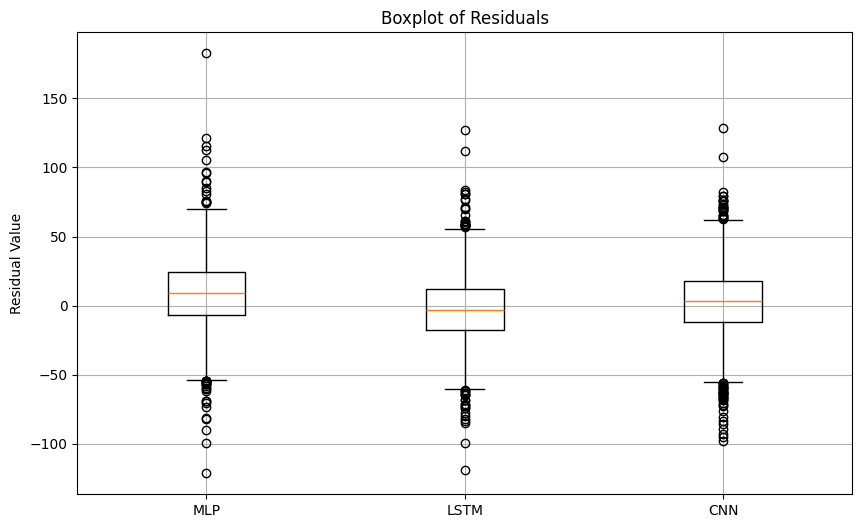

In [28]:
residuals = [actual_labels - x for x in [mlp_predictions, lstm_predictions, cnn_predictions]]
residuals_for_plot = [residual.flatten() for residual in residuals]

labels = ["MLP", "LSTM", "CNN"]

plt.figure(figsize=(10, 6))
plt.boxplot(residuals_for_plot, labels=labels)
plt.title('Boxplot of Residuals')
plt.ylabel('Residual Value')
plt.grid(True)
plt.show()


Comment: 
* MLP using weighted loss function has marginally better performance on low yield data but also the highest variance

* Residuals for all models are symetrical and have mean close to 0 but they are likely not normally distributed

* Potential further improvement could come from data augmentation


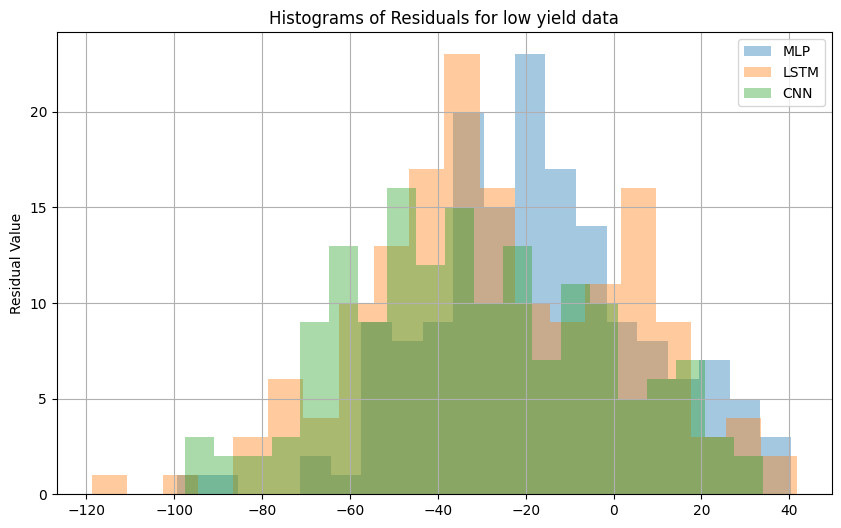

In [29]:
residuals_low_yield = [low_yield_labels - x for x in [mlp_low_predictions, lstm_low_predictions, cnn_low_predictions]]
residuals_for_plot = [residual.flatten() for residual in residuals_low_yield]

labels = ["MLP", "LSTM", "CNN"]

plt.figure(figsize=(10, 6))
for i, residual in enumerate(residuals_for_plot):
    plt.hist(residuals_for_plot[i], bins=20, alpha=0.4, label=labels[i])
    
plt.title('Histograms of Residuals for low yield data')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)
plt.show()